In [1]:
#%matplotlib nbagg

import geofield
import dipole
import scipy, numpy
import newleg
import xyzfield
from matplotlib import pyplot, rcParams
import matplotlib
rcParams.update({'font.family': "Source Sans Pro"})
rcParams.update({'font.size': 14})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib nbagg

In [2]:
import importlib
importlib.reload(dipole); importlib.reload(geofield); importlib.reload(xyzfield); importlib.reload(newleg)

<module 'newleg' from '/home/josecper/Programs/python/newleg.py'>

In [3]:
sha=geofield.SHADIFData("../data/sha.dif.14k/coef_EPSL_tnmgh.dat", "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

__Bootstrap__

In [4]:
iterations = 10000

xs = numpy.zeros((iterations,len(sha.years)))
ys = xs.copy()
zs = xs.copy()

gshort = sha.gcomp[..., :8]
gshort_err = sha.gcomp_err[..., :8] #doesn't exist yet

for i in range(iterations):
    gi = gshort+numpy.random.randn(*gshort.shape)*gshort_err
    xs[i,:], ys[i,:], zs[i,:] = dipole.ecc_dipole(gi)
    
x = xs.sum(axis=0)/iterations
y = ys.sum(axis=0)/iterations
z = zs.sum(axis=0)/iterations

ss, zs, phis = dipole.xyz2cyl(xs,ys,zs)
phis = phis % (2*numpy.pi)
rs = numpy.sqrt(xs**2+ys**2+zs**2)
s, z, phi = dipole.xyz2cyl(x,y,z)
phi = phi % (2*numpy.pi)
r = numpy.sqrt(x**2+y**2+z**2)

s_dev = numpy.sqrt(((ss-s)**2).sum(axis=0)/iterations)
z_dev = numpy.sqrt(((zs-z)**2).sum(axis=0)/iterations)
r_dev = numpy.sqrt(((rs-r)**2).sum(axis=0)/iterations)
phi_dev = numpy.sqrt(((phis-phi)**2).sum(axis=0)/iterations)

del xs, ys, zs, phis, rs, ss

numpy.savetxt("../data/pole_drift/szrphi.txt",
              numpy.array((s,z,r, phi, s_dev, z_dev, r_dev, phi_dev)).T,
              header="#Coordinates of eccentric dipole in km (s, z, r, phi, <errors>)")

<IPython.core.display.Javascript object>


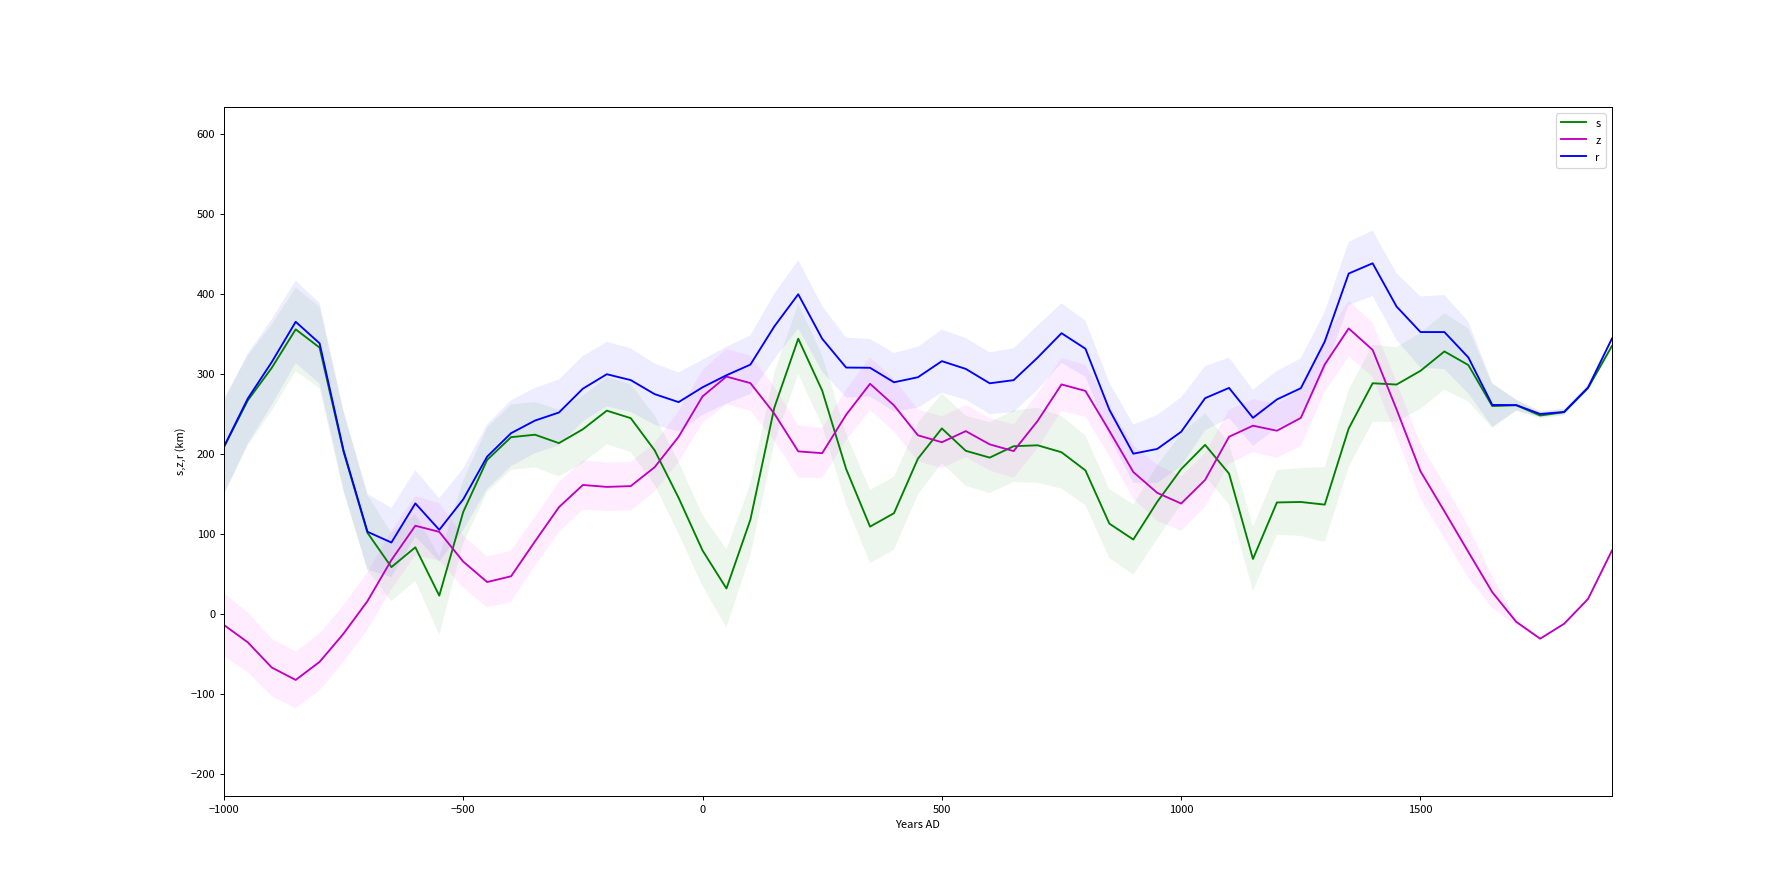

In [5]:
fig, ax = pyplot.subplots(figsize=(20,10))

ax.plot(sha.years, s, color="green", label="s")
ax.plot(sha.years, z, "m-", label="z")
ax.plot(sha.years, r, "b-", label="r")

ax.fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
ax.fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
ax.fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

ax.set_xlabel("Years AD")
ax.set_ylabel("s,z,r (km)")
ax.legend()

ax.set_xbound(-1000,sha.years[-1])

pyplot.show(fig)

<IPython.core.display.Javascript object>


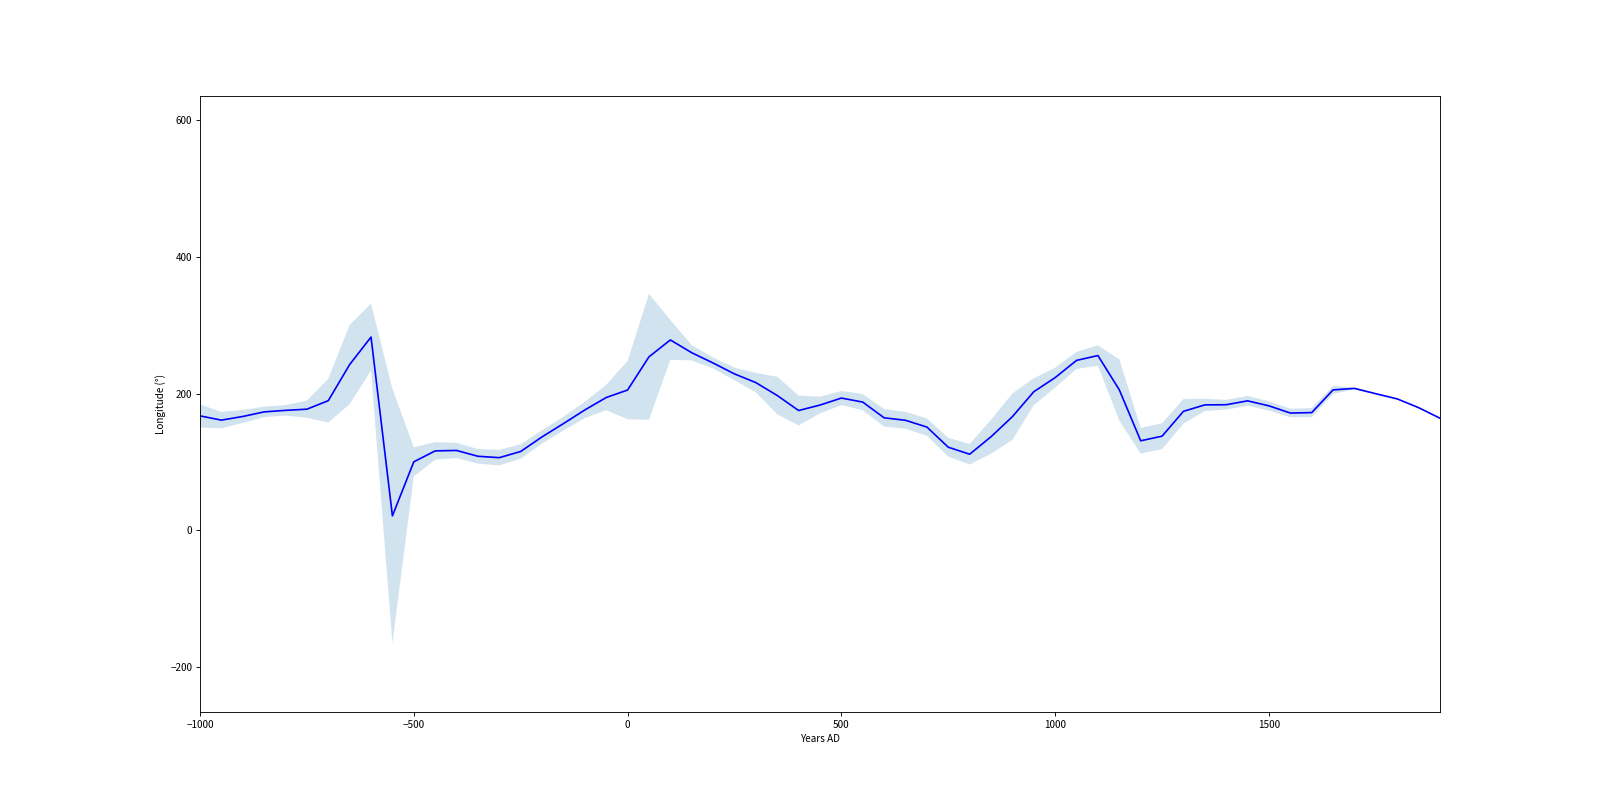

In [6]:
fig, ax = pyplot.subplots(figsize=(20,10))

ax.plot(sha.years, scipy.rad2deg(phi), "b-")
ax.fill_between(sha.years, scipy.rad2deg(phi-phi_dev), scipy.rad2deg(phi+phi_dev), lw=0, alpha=0.2)

ax.set_xlabel("Years AD")
ax.set_ylabel("Longitude (°)")

ax.set_xbound(-1000, sha.years[-1])

pyplot.show(fig)

In [7]:
p_dip=dipole.power(sha.gcomp, lmin=1, lmax=1)
p_quad=dipole.power(sha.gcomp, lmin=2, lmax=2)

In [8]:
power=dipole.power(sha.gcomp, lmin=1, lmax=2, separated=True)
p_sym=power[:,0]+power[:,3]
p_asym=power[:,1:3].sum(axis=1)+power[:,4:8].sum(axis=1)

<IPython.core.display.Javascript object>


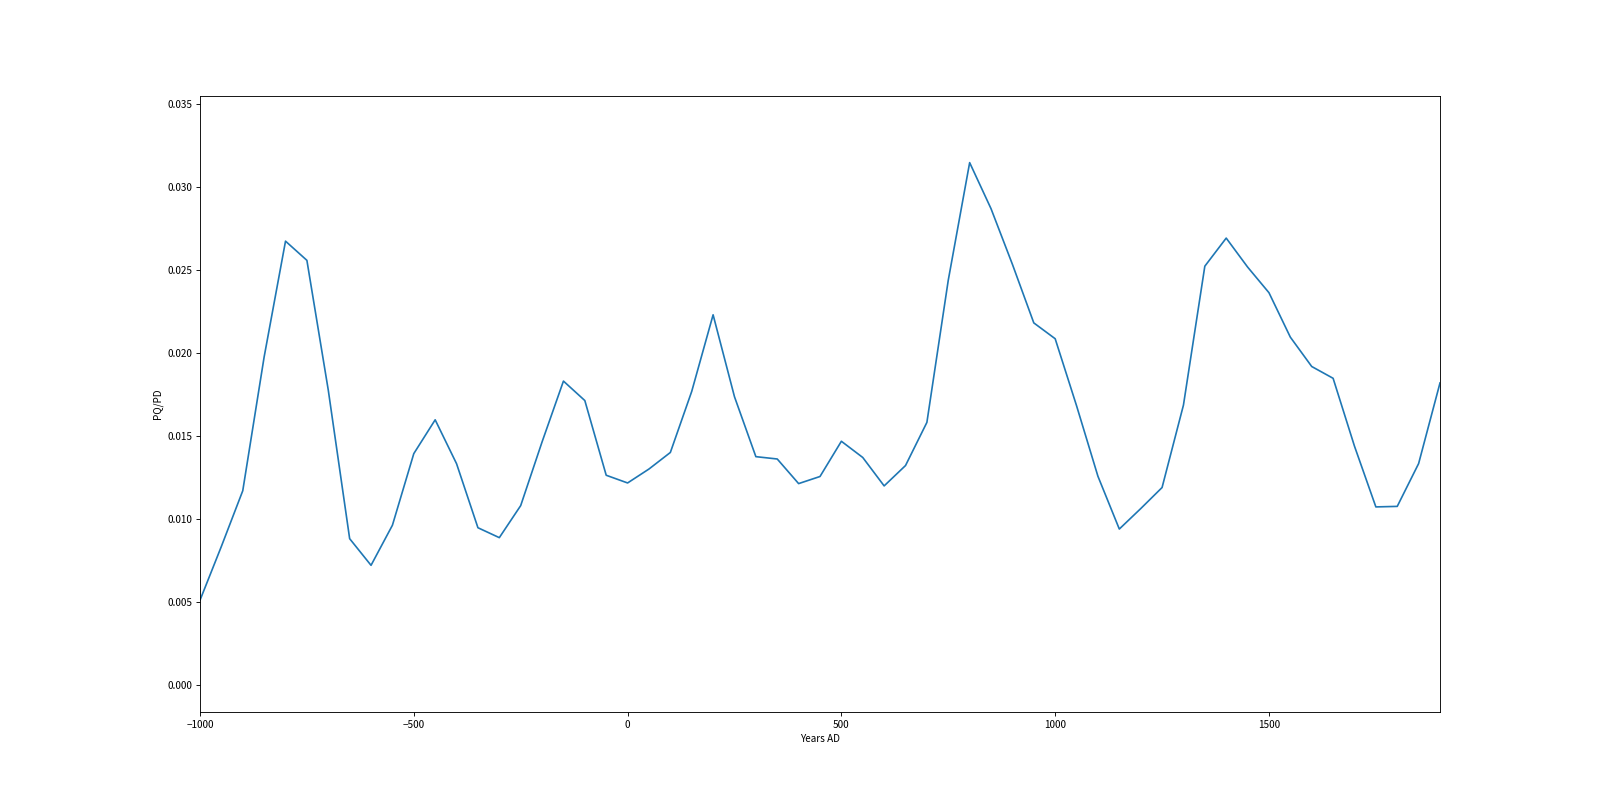

In [9]:
fig, ax = pyplot.subplots(figsize=(20,10))

#ax.plot(sha.years, p_dip)
#ax.plot(sha.years, p_quad)

ax.plot(sha.years, p_quad/p_dip)

ax.set_xbound(-1000, sha.years[-1])
ax.set_xlabel("Years AD")
ax.set_ylabel("PQ/PD")
pyplot.show(fig)

<IPython.core.display.Javascript object>


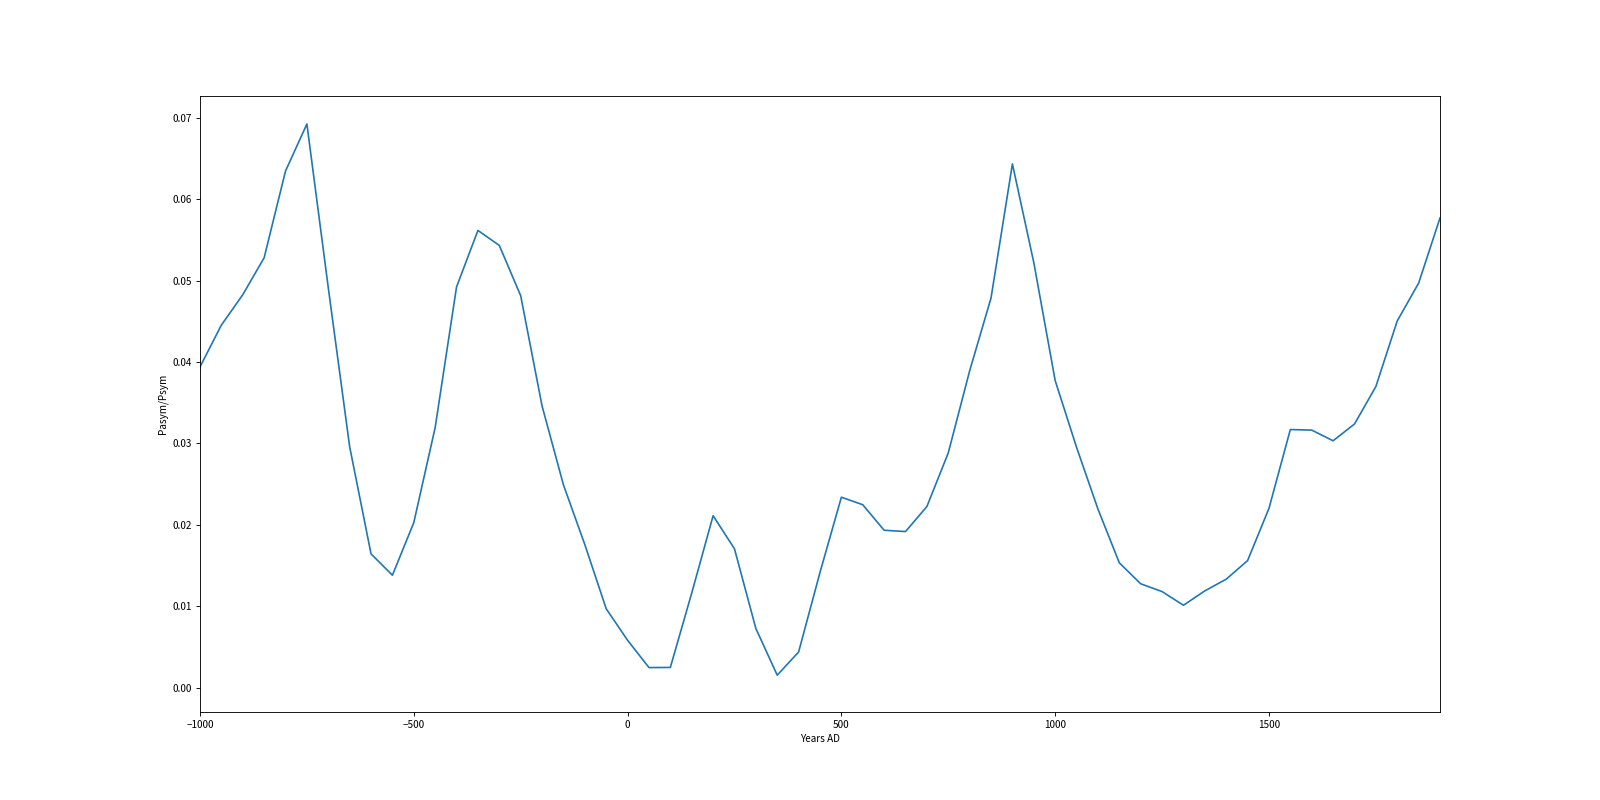

In [10]:
fig, ax = pyplot.subplots(figsize=(20,10))

#ax.plot(sha.years, p_dip)
#ax.plot(sha.years, p_quad)

ax.plot(sha.years, p_asym/p_sym)

ax.set_xbound(-1000, sha.years[-1])
ax.set_xlabel("Years AD")
ax.set_ylabel("Pasym/Psym")
pyplot.show(fig)

In [11]:
from mpl_toolkits import mplot3d

<IPython.core.display.Javascript object>


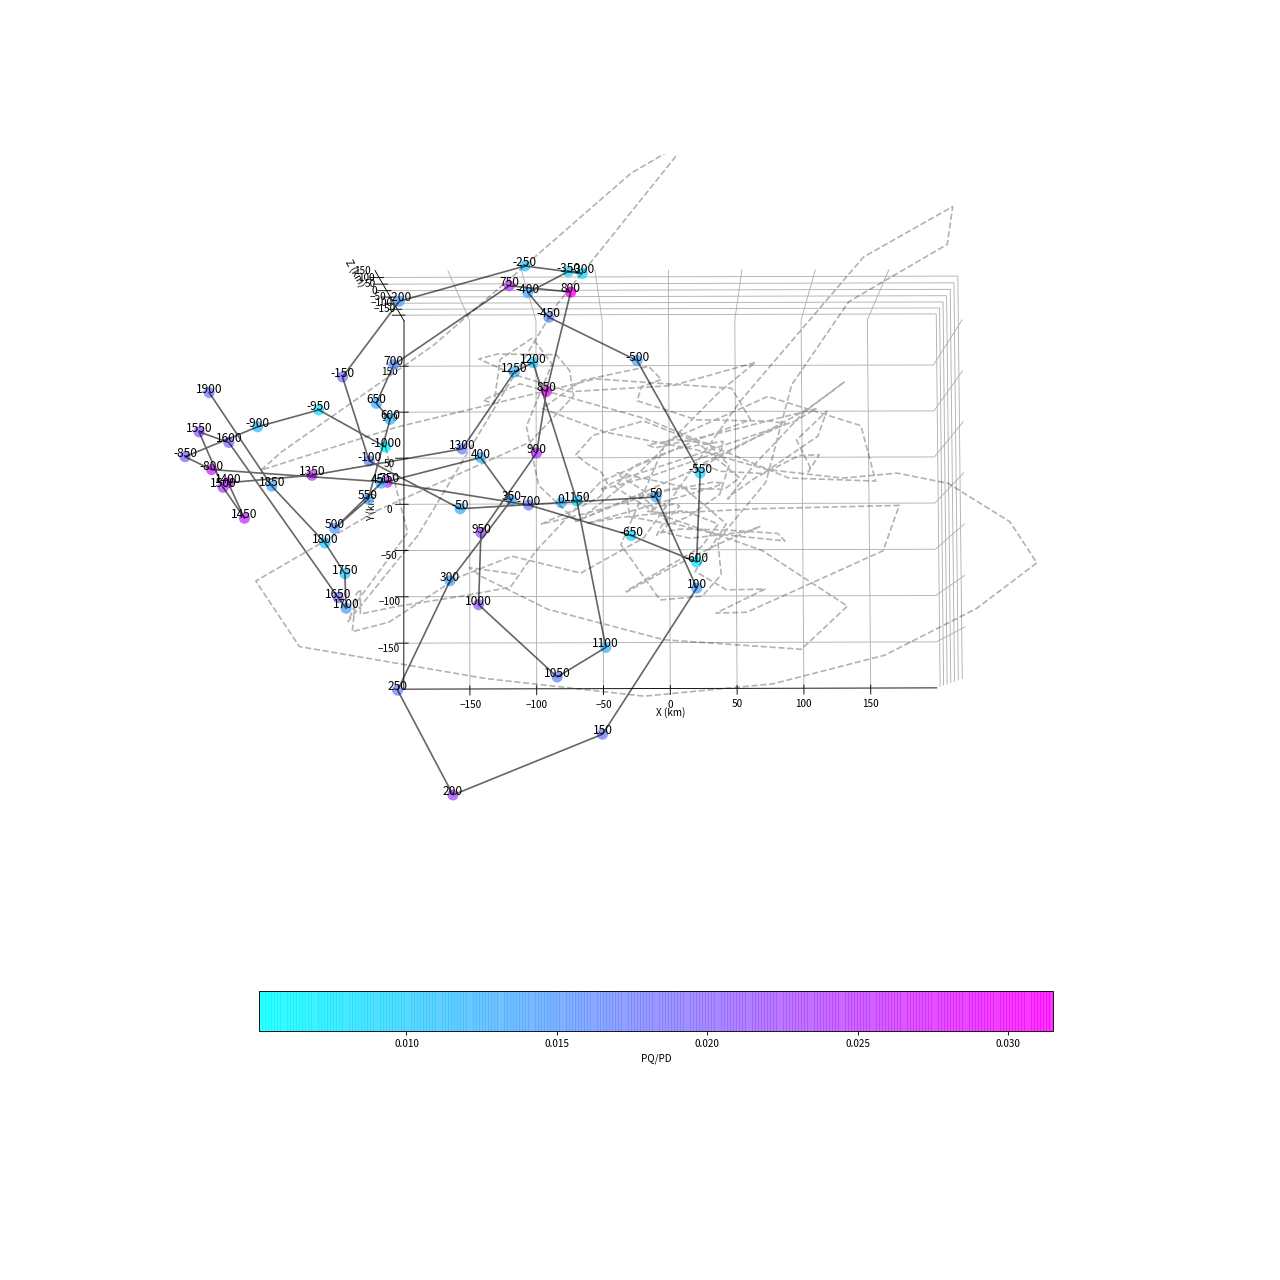

In [12]:
fig = pyplot.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

years = numpy.array(sha.years)

ax.plot(x[years >= -1000],y[years >= -1000],z[years >= -1000], alpha=0.6, color="black")
ax.plot(x[years <= -1000],y[years <= -1000],z[years <= -1000], alpha=0.3, color="black", ls="--")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

xs = x[years >= -1000]; ys=y[years >= -1000]; zs=z[years >= -1000]; ts=years[years >= -1000]

for xi,yi,zi,ti in zip(xs,ys,zs,ts):
    ax.text(xi,yi,zi,str(int(ti)), fontsize=12, horizontalalignment="center")
       
c=ax.scatter(xs,ys,zs,
           #s=(30000*p_quad/p_dip)[years >= -1000],
           #c="b",
           c=(p_quad/p_dip)[years >= -1000],
           s=100,
           lw=0, alpha=0.8,
           cmap="cool")

ax.set_xbound(-max(abs(r))*1.05, max(abs(r))*1.05)
ax.set_ybound(-max(abs(r))*1.05, max(abs(r))*1.05)
ax.set_zbound(-max(abs(r))*1.05, max(abs(r))*1.05)

pyplot.colorbar(mappable=c, ax=ax, label="PQ/PD", orientation="horizontal", shrink=0.8)

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")

In [ ]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

years = numpy.array(sha.years)

ax.plot(x[years >= -1000],y[years >= -1000],z[years >= -1000])
ax.plot(x[years <= -1000],y[years <= -1000],z[years <= -1000], alpha=0.4, color="blue")


u = numpy.linspace(0, 2 * numpy.pi, 100)
v = numpy.linspace(0, numpy.pi, 100)

xn = 3520 * numpy.outer(numpy.cos(u), numpy.sin(v)) 
yn = 3520 * numpy.outer(numpy.sin(u), numpy.sin(v))
zn = 3520 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
ax.plot_surface(xn, yn, zn, rstride=4, cstride=4, color='k', linewidth=0, shade=False, alpha=0.1)
xn = 1220 * numpy.outer(numpy.cos(u), numpy.sin(v))
yn = 1220 * numpy.outer(numpy.sin(u), numpy.sin(v))
zn = 1220 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
ax.plot_surface(xn, yn, zn, rstride=4, cstride=4, color='w', linewidth=0, shade=False, alpha=1.0)

ax.scatter(x[-1],y[-1],z[-1])

In [ ]:
dip_theta, dip_phi = dipole.coords(sha.gcomp)

In [ ]:
fig, axes = pyplot.subplots(5,1,figsize=(8,14))

axes[0].plot(sha.years, numpy.rad2deg(dip_theta),
        #sha.years, numpy.rad2deg(dip_phi), "+"
       )
axes[0].set_xbound(-1000, sha.years[-1])
axes[0].set_xlabel("Years AD")
axes[0].set_ylabel("Dip. colatitude (º)")

axes[1].plot(sha.years, s, color="green", label="s")
axes[1].plot(sha.years, z, "m-", label="z")
axes[1].plot(sha.years, r, "b-", label="r")

axes[1].fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
axes[1].fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
axes[1].fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

axes[1].set_xlabel("Years AD")
axes[1].set_ylabel("s,z,r (km)")
axes[1].legend()

axes[1].set_xbound(-1000,sha.years[-1])

axes[2].plot(sha.years, scipy.rad2deg(phi), "b-")
axes[2].fill_between(sha.years, scipy.rad2deg(phi-phi_dev), scipy.rad2deg(phi+phi_dev), lw=0, alpha=0.2)

axes[2].set_xlabel("Years AD")
axes[2].set_ylabel("Longitude (°)")

axes[2].set_xbound(-1000, sha.years[-1])

axes[3].plot(sha.years, p_quad/p_dip)

axes[3].set_xbound(-1000, sha.years[-1])
axes[3].set_xlabel("Years AD")
axes[3].set_ylabel("PQ/PD")

pyplot.tight_layout()
pyplot.show(fig)

In [ ]:
import xyzfield; import newleg; import fibonacci_sphere
theta,phi=fibonacci_sphere.grid(10000)

In [ ]:
from mpl_toolkits.basemap import Basemap

__Entropy__

In [ ]:
order = 10
prob = numpy.zeros((len(sha.years),order))

In [ ]:
pow_total = numpy.zeros_like(sha.years)

for l in range(order):
    power = dipole.power(sha.gcomp, l+1, l+1)
    prob[:,l] = power
    pow_total += power
    
prob = prob / pow_total[:, numpy.newaxis]

info = numpy.zeros_like(prob)
info[prob != 0] = prob[prob != 0] * numpy.log(prob[prob != 0])

info = info.sum(axis=1)

k_entropy = -numpy.gradient(info, 50)
d_k_entropy = numpy.gradient(k_entropy,50)

In [ ]:
fig, (ax1,ax4,ax3,ax5,ax2) = pyplot.subplots(5,1, figsize=(25,25))

years = numpy.array(sha.years)

ax1.plot(years, info)
ax2.plot(years, k_entropy)

ax2.set_xlabel("Years AD")
ax1.set_ylabel("Information content")
ax2.set_ylabel("Entropy (Years$^{-1}$)")
#ax.plot(years, numpy.polyval(poly, years))

ax3.plot(sha.years, s, color="green", label="s")
ax3.plot(sha.years, z, "m-", label="z")
ax3.plot(sha.years, r, "b-", label="r")

ax3.fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
ax3.fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
ax3.fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

ax3.set_xlabel("Years AD")
ax3.set_ylabel("s,z,r (km)")
ax3.legend(loc="upper left")

#ax3.set_xbound(-2000,sha.years[-1])

ax4.plot(sha.years, p_quad/p_dip)

#ax4.set_xbound(-2000, sha.years[-1])
ax4.set_xlabel("Years AD")
ax4.set_ylabel("PQ/PD")

ax5.plot(years, d_k_entropy, "k")
ax5.set_ylabel("dK/dt")

def onclick(event):
    for ax in (ax1, ax2, ax3, ax4, ax5):
        if event.inaxes is ax3:
            ax.plot([event.xdata, event.xdata], [-1000,1000], "r--", scaley=False)
        else:
            ax.plot([event.xdata, event.xdata], [-1000,1000], "k--", scaley=False)
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)

pyplot.tight_layout()
pyplot.show(fig)

Notas:

- Picos de PQ/PD coinciden con picos de baja información (obvio porque el dipolo es la mayoría de la energía, el aumento relativo de otras componentes siempre conlleva mayor "reparto" o menor información.
- Picos de info == entropía cero

__Ahora con lmax = 4__

In [ ]:
northlons_1, northlats_1 = xyzfield.magnetic_north(sha.gcomp, 1, south=False)
northlons_2, northlats_2 = xyzfield.magnetic_north(sha.gcomp, 2, south=False)
northlons_4, northlats_4 = xyzfield.magnetic_north(sha.gcomp, 4, south=False)
northlons_10, northlats_10 = xyzfield.magnetic_north(sha.gcomp, 10, south=False)

In [ ]:
northlons_1, northlats_1 = xyzfield.magnetic_north(sha.gcomp, 1, south=False)

In [ ]:
nlatest_1=90-abs(90-numpy.array(northlats_1))[numpy.array(sha.years) >= starting_time]
nlontest_1=(numpy.array(northlons_1) % 360)[numpy.array(sha.years) >= starting_time]

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(2,1)

ax1.plot(sha.years, northlons_1, "b-")
ax2.plot(sha.years, northlats_1, "b-")

pyplot.show(fig)

In [ ]:
northlon_max=[]
northlat_max=[]

theta, phi = fibonacci_sphere.grid(40000)

for i,year in enumerate(sha.years):
    x,y,z = xyzfield.xyzfieldv2(sha.gcomp[i], phi, theta)
    inc = numpy.arctan2(z,numpy.sqrt(x**2+y**2))
    northlon_max.append(numpy.rad2deg(phi[inc == numpy.max(inc)]))
    northlat_max.append(90-numpy.rad2deg(theta[inc == numpy.max(inc)]))
    
    #print("year: {0:<25} {1}".format(int(year), (northlon_max[-1], northlat_max[-1])))

In [ ]:
starting_time = -2000

In [ ]:
magnetic_north_data = numpy.loadtxt("../data/sha.dif.14k/magnetic_north.csv",delimiter=",")

magnetic_north_data = magnetic_north_data[magnetic_north_data[:,0] > starting_time]

magnetic_north_years = magnetic_north_data[:, 0]
magnetic_north_lat = magnetic_north_data[:, 1]
magnetic_north_lon = magnetic_north_data[:, 2]

In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
base = Basemap(projection='npstere',boundinglat=69,lon_0=0,resolution='l')

fig, (ax,ax1,ax4,ax3,ax2) = pyplot.subplots(5,1,figsize=(20,55), gridspec_kw={"height_ratios" : [4,1,1,1,1]})
base.drawcoastlines(ax=ax, linewidth=0.2)
base.drawparallels(numpy.arange(-60.,90.,10.),ax=ax, linewidth=0.3)
base.drawmeridians(numpy.arange(0.,420.,30.),labels=[0,0,0,1],fontsize=10,ax=ax, linewidth=0.3)
base.drawmapboundary(ax=ax)

years_post=numpy.array(sha.years)[numpy.array(sha.years) >= starting_time]

nlatest_1=90-abs(90-numpy.array(northlats_1))[numpy.array(sha.years) >= starting_time]
nlontest_1=(numpy.array(northlons_1) % 360)[numpy.array(sha.years) >= starting_time]

nlatest_2=90-abs(90-numpy.array(northlats_2))[numpy.array(sha.years) >= starting_time]
nlontest_2=(numpy.array(northlons_2) % 360)[numpy.array(sha.years) >= starting_time]

nlatest_4=90-abs(90-numpy.array(northlats_4))[numpy.array(sha.years) >= starting_time]
nlontest_4=(numpy.array(northlons_4) % 360)[numpy.array(sha.years) >= starting_time]

nlatest_10=90-abs(90-numpy.array(northlats_10))[numpy.array(sha.years) >= starting_time]
nlontest_10=(numpy.array(northlons_10) % 360)[numpy.array(sha.years) >= starting_time]

years=[-1400.0, -800.0, -400.0, -100.0, 200.0, 800.0, 1400.0]
okyears=[]

x_all, y_all = base(nlontest_2, nlatest_2)

x_dots=x_all[numpy.in1d(sha.years, okyears)]
y_dots=y_all[numpy.in1d(sha.years, okyears)]

#base.plot(magnetic_north_lon, magnetic_north_lat, latlon=True, ax=ax,
#          c="#AA5CD1", marker="o", markeredgecolor="None", linewidth=0.2, label="Magnetic north (Pavón et al. 2014)")

#base.plot(nlontest, nlatest, latlon=True, ax=ax,
#          c="#026060", marker="o", markeredgecolor="None", linewidth=0.2, label="Magnetic north (optimized)")

base.plot(nlontest_1, nlatest_1, latlon=True, ax=ax,
          c="#3172EB", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Geomagnetic north ($l_{max} = 1$)")

base.plot(nlontest_2, nlatest_2, latlon=True, ax=ax,
          c="#D11B5B", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Magnetic north ($l_{max} = 2$)")

base.plot(nlontest_4, nlatest_4, latlon=True, ax=ax,
          c="#D6BC13", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Magnetic north ($l_{max} = 4$)")

base.plot(nlontest_10, nlatest_10, latlon=True, ax=ax,
          c="#23BA97", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Magnetic north ($l_{max} = 10$)")

for xi, yi, year in list(zip(x_dots, y_dots, okyears)):
    ax.text(xi,yi,str(year), fontsize=16)

ax.legend(loc="upper right")
    
def set_year(event):
    
    if event.inaxes is ax:  
        distance = (x_all - event.xdata)**2 + (y_all - event.ydata)**2
        year = numpy.array(years_post)[distance == numpy.min(distance)][0]
        x = x_all[distance == numpy.min(distance)]
        y = y_all[distance == numpy.min(distance)]
        #ax.text(x,y,str(year), fontsize=16, color="#026060")
        ax.annotate(str(year),(x,y), fontsize=16, color="#026060", xytext=(-40,30), textcoords="offset points", arrowprops={"color":"#026060", "arrowstyle":"->", "connectionstyle":"arc3"})
    elif event.inaxes is ax3:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=16, color="red", xytext=(-50,0), textcoords="offset points", arrowprops={"color":"red", "arrowstyle":"->", "connectionstyle":"arc3"})
    else:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=16, color="black", xytext=(-40,-30), textcoords="offset points", arrowprops={"color":"black", "arrowstyle":"->", "connectionstyle":"arc3"})    
    
    for axi in (ax1, ax2, ax3, ax4):        
        if event.inaxes is ax3:
            axi.plot([event.xdata, event.xdata], [-1000,1000], "r--", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), event.xdata))
        elif event.inaxes is ax:
            axi.plot([year, year], [-1000,1000], ls="--", color="#026060", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), year))
        else:
            axi.plot([event.xdata, event.xdata], [-1000,1000], "k--", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), event.xdata))
        axi.set_xbound(starting_time, 1900)
    
#base.scatter(southlons, southlats, latlon=True, ax=ax,c="#FFFFFF", marker="o", edgecolor="blue")

#base.fillcontinents(color='coral',lake_color='aqua', zorder=0)
#base.bluemarble(scale=0.25, zorder=0)
#base.warpimage(image="../../Pictures/Captura de pantalla_2016-06-09_12-41-41.png")

years = numpy.array(sha.years)

ax1.plot(years, info)
ax2.plot(years, k_entropy)

ax2.set_xlabel("Years AD")
ax1.set_ylabel("Information content")
ax2.set_ylabel("Entropy (Years$^{-1}$)")
#ax.plot(years, numpy.polyval(poly, years))

ax3.plot(sha.years, s, color="green", label="s")
ax3.plot(sha.years, z, "m-", label="z")
ax3.plot(sha.years, r, "b-", label="r")

ax3.fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
ax3.fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
ax3.fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

ax3.set_xlabel("Years AD")
ax3.set_ylabel("s,z,r (km)")
ax3.legend(loc="upper left")

#ax3.set_xbound(-2000,sha.years[-1])

ax4.plot(sha.years, p_quad/p_dip)

#ax4.set_xbound(-2000, sha.years[-1])
ax4.set_xlabel("Years AD")
ax4.set_ylabel("PQ/PD")

for axi in (ax1, ax2, ax3, ax4):
    axi.set_xbound(starting_time, 1900)
    axi.xaxis.set_tick_params(labelsize=12)

#ax5.plot(years, d_k_entropy, "k")
#ax5.set_ylabel("dK/dt")

cid=fig.canvas.mpl_connect("button_press_event", set_year)

fig.tight_layout()
pyplot.show(fig)

__Yes i had idea good__

In [ ]:
def arc_dist(lat1, lon1, lat2, lon2, units="rad"):
    if units == "deg":
        lat1, lon1, lat2, lon2 = numpy.deg2rad((lat1, lon1, lat2, lon2))
    
    return numpy.arctan2(numpy.sqrt((numpy.cos(lat2)*numpy.sin(numpy.abs(lon2-lon1)))**2 + (numpy.cos(lat1)*numpy.sin(lat2) - numpy.sin(lat1)*numpy.cos(lat2)*numpy.cos(numpy.abs(lon2-lon1)))**2),numpy.sin(lat1)*numpy.sin(lat2) + numpy.cos(lat1)*numpy.cos(lat2)*numpy.cos(numpy.abs(lat2-lat1)))
    #return numpy.arccos(numpy.sin(lat1)*numpy.sin(lat2) + numpy.cos(lat1)*numpy.cos(lat2)*numpy.cos(lon2-lon1))
    
def avg_dist(lats, lons):
    
    dist = numpy.empty_like(lats)
    dist[0] = arc_dist(lats[0], lons[0], lats[1], lons[1])
    dist[-1] = arc_dist(lats[-1], lons[-1], lats[-2], lons[-2])
    dist[1:-1] = (arc_dist(lats[0:-2], lons[0:-2], lats[1:-1], lons[1:-1])+arc_dist(lats[1:-1], lons[1:-1], lats[2:], lons[2:]))/2
    return dist


angularv_2 = numpy.sqrt(numpy.rad2deg(arc_dist(numpy.deg2rad(nlatest_2[1:]),
                                 numpy.deg2rad(nlontest_2[1:]),
                                 numpy.deg2rad(nlatest_2[:-1]),
                                 numpy.deg2rad(nlontest_2[:-1]))**2/(50**2)))

In [ ]:
from matplotlib import gridspec

base = Basemap(projection='npstere',
               boundinglat=70,
               lon_0=0,
               resolution='l')

fig = pyplot.figure(figsize=(22,10))

gs = gridspec.GridSpec(4, 2, wspace=0.05)

ax = pyplot.subplot(gs[:, 1])
ax1 = pyplot.subplot(gs[0, 0])
ax2 = pyplot.subplot(gs[1, 0])
ax3 = pyplot.subplot(gs[2, 0])
ax4 = pyplot.subplot(gs[3, 0])

for axi in (ax, ax1, ax2, ax3, ax4): fig.add_axes(axi)
    
base.drawcoastlines(ax=ax, linewidth=0.2)
base.drawparallels(numpy.arange(-60.,90.,5.),ax=ax, linewidth=0.3)
base.drawmeridians(numpy.arange(0.,420.,10.),labels=[0,0,0,1],fontsize=10,ax=ax, linewidth=0.3, latmax=85)
base.drawmapboundary(ax=ax)

x_all, y_all = base(nlontest_10, nlatest_10)

okyears=[]
x_dots=x_all[numpy.in1d(sha.years, okyears)]
y_dots=y_all[numpy.in1d(sha.years, okyears)]

base.plot(nlontest_1, nlatest_1, latlon=True, ax=ax,
          c="#3172EB", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Geomagnetic north ($l_{max} = 1$)")

base.plot(nlontest_2, nlatest_2, latlon=True, ax=ax,
          c="#D11B5B", marker="o", markeredgecolor="None", linewidth=0.3, label="Magnetic north ($l_{max} = 2$)",
          markersize=2.5)

#x_tan, y_tan = numpy.array(base(nlontest_2 + tan_lon, nlatest_2 + tan_lat)) - base(nlontest_2, nlatest_2)
#base.quiver(nlontest_2, nlatest_2, x_tan, y_tan, latlon=True, ax=ax, width=0.0005)

#base.plot(nlontest_4, nlatest_4, latlon=True, ax=ax,
#          c="#D6BC13", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Magnetic north ($l_{max} = 4$)")

base.plot(nlontest_10, nlatest_10, latlon=True, ax=ax,
          c="#139A67", marker="o", markersize=4.5, markeredgecolor="None", linewidth=0.7, label="Magnetic north ($l_{max} = 10$)")

#base.plot(magnetic_north_lon, magnetic_north_lat, latlon=True, ax=ax,
#          c="#777777", marker="o", markersize=2.5, markeredgecolor="None", linewidth=0.3, label="Magnetic north (Pavón et al. 2014)")

for xi, yi, year in list(zip(x_dots, y_dots, okyears)):
    ax.text(xi,yi,str(year), fontsize=16)

ax.legend(loc="upper right", fontsize="small")
    
def set_year(event):
    
    if event.inaxes is ax:  
        distance = (x_all - event.xdata)**2 + (y_all - event.ydata)**2
        year = numpy.array(years_post)[distance == numpy.min(distance)][0]
        x = x_all[distance == numpy.min(distance)]
        y = y_all[distance == numpy.min(distance)]
        #ax.text(x,y,str(year), fontsize=16, color="#026060")
        ax.annotate(str(year),(x,y), fontsize=9, color="#D11B5B", xytext=(-40,30), textcoords="offset points", arrowprops={"color":"#D11B5B", "arrowstyle":"->", "connectionstyle":"arc3"})
    elif event.inaxes is ax1:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=9, color="#9B14DE", xytext=(0,20), textcoords="offset points", arrowprops={"color":"#9B14DE", "arrowstyle":"->", "connectionstyle":"arc3"})
    elif event.inaxes is ax3:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=9, color="red", xytext=(-50,0), textcoords="offset points", arrowprops={"color":"red", "arrowstyle":"->", "connectionstyle":"arc3"})
    elif event.inaxes is ax2:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=9, color="#CB19E3", xytext=(20,0), textcoords="offset points", arrowprops={"color":"#CB19E3", "arrowstyle":"->", "connectionstyle":"arc3"})
    else:
        closest_i= numpy.abs(numpy.array(years_post)-event.xdata).argmin()
        year=years_post[closest_i]
        ax.annotate(str(year), (x_all[closest_i], y_all[closest_i]), fontsize=9, color="black", xytext=(-40,-30), textcoords="offset points", arrowprops={"color":"black", "arrowstyle":"->", "connectionstyle":"arc3"})    
    
    for axi in (ax1, ax2, ax3, ax4):        
        if event.inaxes is ax3:
            axi.plot([event.xdata, event.xdata], [-1000,1000], "r--", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), event.xdata))
        elif event.inaxes is ax:
            axi.plot([year, year], [-1000,1000], ls="--", color="#D11B5B", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), year))
        elif event.inaxes is ax2:
            axi.plot([year, year], [-1000,1000], ls="--", color="#CB19E3", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), year))
        elif event.inaxes is ax1:
            axi.plot([event.xdata, event.xdata], [-1000,1000], ls="--", color="#9B14DE", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), event.xdata))
        else:
            axi.plot([event.xdata, event.xdata], [-1000,1000], "k--", scaley=False)
            axi.xaxis.set_ticks(numpy.append(axi.xaxis.get_ticklocs(), event.xdata))
        axi.set_xbound(starting_time, 1900)
        
    event.canvas.draw()
    
#base.scatter(southlons, southlats, latlon=True, ax=ax,c="#FFFFFF", marker="o", edgecolor="blue")

#base.fillcontinents(color='coral',lake_color='aqua', zorder=0)
#base.bluemarble(scale=0.25, zorder=0)
#base.warpimage(image="../../Pictures/Captura de pantalla_2016-06-09_12-41-41.png")

years = numpy.array(sha.years)

#ax1.plot(years, info)
#ax2.plot(years[years >= starting_time][:-1], angularv_2)

#ax1.set_ylabel("Information content")
#ax2.set_ylabel("Pole velocity (º Years$^{-1}$) ")
#ax.plot(years, numpy.polyval(poly, years))

ax1.plot(years[years >= starting_time][:-1], curvature[:-1], color="#9B14DE")
ax1.plot(years[years >= starting_time][:-2], curv_filtered[2:], color="#9B14DE", ls="--")
ax1.set_ylabel("Pole drift curvature (º Years$^{-2}$)")

ax2.plot(years[years >= starting_time], intensities[years >= starting_time])
ax2.set_ylabel("Average field intensity ($\mu$T)")


ax3.plot(sha.years, s, color="green", label="s")
ax3.plot(sha.years, z, "m-", label="z")
ax3.plot(sha.years, r, "b-", label="r")

ax3.fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
ax3.fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
ax3.fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

ax3.set_ylabel("s,z,r (km)")
ax3.legend(loc="lower center", fontsize="x-small", ncol=3)

#ax3.set_xbound(-2000,sha.years[-1])

ax4.plot(sha.years, p_quad/p_dip)

#ax4.set_xbound(-2000, sha.years[-1])
ax4.set_xlabel("Years AD")
ax4.set_ylabel("PQ/PD")

for axi in (ax1, ax2, ax3, ax4):
    axi.set_xbound(starting_time, 1900)
    axi.xaxis.set_tick_params(labelsize=9)

#ax5.plot(years, d_k_entropy, "k")
#ax5.set_ylabel("dK/dt")

cid=fig.canvas.mpl_connect("button_press_event", set_year)

pyplot.show(fig)

In [ ]:
intensities = numpy.empty_like(sha.years)
npoints = len(phi)

for i, year in enumerate(sha.years):
    x,y,z = xyzfield.xyzfieldv2(sha.gcomp[i, :], phi, theta)
    dec,inc,f,h = xyzfield.xyz2difh(x,y,z)
    intensities[i]=(f.sum(axis=0)/npoints)

In [ ]:
#curvature
#tan_lat, tan_lon = numpy.diff((nlatest_2, nlontest_2), axis=1)/50
#curvature = numpy.sqrt(numpy.diff(tan_lat)**2 + numpy.diff(tan_lon)**2)/numpy.rad2deg(arc_dist(nlatest_2[2:], nlontest_2[2:], nlatest_2[:-2], nlontest_2[:-2], units="deg"))

#tan_lon = (nlontest_2[1:] - nlontest_2[:-1])/50

nlontest_2r, nlatest_2r = numpy.deg2rad(northlons_2)[years >= starting_time], numpy.pi-numpy.deg2rad(northlats_2)[years >= starting_time]

#tan_lon = numpy.rad2deg(numpy.arctan2(numpy.sin(nlontest_2r[1:] - nlontest_2r[:-1]), numpy.cos(nlontest_2r[1:] - nlontest_2r[:-1]))/50)
tan_lon = numpy.sin(numpy.pi/2-nlatest_2r)*numpy.rad2deg(numpy.arctan2(numpy.sin(numpy.ediff1d(nlontest_2r, to_begin=0)), numpy.cos(numpy.ediff1d(nlontest_2r, to_begin=0)))/50)

#tan_lat = numpy.rad2deg(numpy.arctan2(numpy.sin(nlatest_2r[1:] - nlatest_2r[:-1]), numpy.cos(nlatest_2r[1:] - nlatest_2r[:-1]))/50)
tan_lat = numpy.rad2deg(numpy.arctan2(numpy.sin(numpy.ediff1d(nlatest_2r, to_begin=0)), numpy.cos(numpy.ediff1d(nlatest_2r, to_begin=0)))/50)

#curvature = numpy.sqrt(numpy.gradient(tan_lat)**2 + numpy.gradient(tan_lon)**2)/numpy.rad2deg(arc_dist(nlatest_2r[1:], nlontest_2r[1:], nlatest_2r[:-1], nlontest_2r[:-1]))
curvature = numpy.sqrt(numpy.gradient(tan_lat)**2 + numpy.gradient(tan_lon)**2)/numpy.rad2deg(avg_dist(nlatest_2r, nlontest_2r))

In [ ]:
import scipy.interpolate

In [ ]:
years_post=years[years >= starting_time]

years_post_smoothed=numpy.linspace(years_post[0], years_post[-1], 3000)

slon=scipy.interpolate.UnivariateSpline(years_post, nlontest_2, s=0.1)(years_post_smoothed)
slat=scipy.interpolate.UnivariateSpline(years_post, nlatest_2, s=0.1)(years_post_smoothed)

tan_lon = numpy.sin(numpy.pi-slat)*numpy.rad2deg(numpy.arctan2(numpy.sin(numpy.gradient(slon)), numpy.cos(numpy.gradient(slon)))/50)
tan_lat = numpy.rad2deg(numpy.arctan2(numpy.sin(numpy.gradient(slat)), numpy.cos(numpy.gradient(slat)))/50)

curvature = scipy.interpolate.InterpolatedUnivariateSpline(years_post_smoothed, numpy.sqrt(numpy.gradient(tan_lat)**2 + numpy.gradient(tan_lon)**2)/numpy.rad2deg(avg_dist(slat, slon)))(years_post)
curvature = numpy.sqrt(numpy.gradient(tan_lat)**2 + numpy.gradient(tan_lon)**2)/numpy.rad2deg(avg_dist(slat, slon))


In [ ]:
fig, axes = pyplot.subplots(3,1)

axes[0].plot(years_post, nlontest_2)
axes[1].plot(years_post, nlatest_2)

pyplot.show(fig)

In [ ]:
slon=scipy.interpolate.UnivariateSpline(years_post, nlontest_10, s=1)(years_post)
slat=scipy.interpolate.UnivariateSpline(years_post, nlatest_10, s=1)(years_post)

#change this to use an equal-distance projection so tangent vector is accurate

fake_map = Basemap(projection='npaeqd',boundinglat=0,lon_0=0,resolution='l')

xx, yy = fake_map(slon, slat)
difx, dify = numpy.gradient(xx)/6371000, numpy.gradient(yy)/6371000
tan_len = numpy.sqrt(difx**2 + dify**2)/50

curvature = (numpy.gradient(difx)**2 + numpy.gradient(dify)**2)/tan_len

In [ ]:
numpy.arctan2(numpy.sin(numpy.ediff1d(numpy.deg2rad(nlontest_2))), numpy.cos(numpy.ediff1d(numpy.deg2rad(nlontest_2)))).shape

In [ ]:
import scipy.signal
b, a=scipy.signal.butter(4, 1/2, btype="low")
curv_filtered = scipy.signal.lfilter(b, a, curvature)
#curv_filtered = scipy.signal.medfilt(curvature, 3)

In [ ]:
#magic curv



### curva de declinación

In [ ]:
paris_lat, paris_lon = 48.8566, 2.3522

In [ ]:
declinations = numpy.empty_like(sha.years)
inclinations = numpy.empty_like(sha.years)

starting_time = -2000
years = numpy.array(sha.years)

for i, y in enumerate(sha.years):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(sha.gcomp[i, :],
                                                        numpy.deg2rad([paris_lon]),
                                                        numpy.deg2rad([90-paris_lat])))
    declinations[i] = dec
    inclinations[i] = inc
    
dec_degrees = numpy.rad2deg(declinations[years >= starting_time])
inc_degrees = numpy.rad2deg(inclinations[years >= starting_time])

In [ ]:
fig, axes = pyplot.subplots(2,1)

axes[0].plot(years_post, numpy.rad2deg(declinations[years >= starting_time]))
axes[1].plot(years_post, numpy.rad2deg(inclinations[years >= starting_time]))

pyplot.show(fig)

In [ ]:
fig, ax = pyplot.subplots()

base2 = Basemap(projection='npstere',
                lat_0=90, boundinglat = 50,
                lon_0=180,resolution='l')

base2.drawparallels(numpy.arange(50,90,10.), ax=ax)
base2.drawmeridians(numpy.arange(-30,35,5.), ax=ax)

base2.plot(-dec_degrees,
           inc_degrees,
           latlon=True, ax=ax,
           linewidth=1.0,
           marker="o", markeredgecolor="None",
           color="#D11B5B")

x_dots, y_dots = base2(-dec_degrees, inc_degrees)

for xi, yi, year in list(zip(x_dots, y_dots, years[years >= starting_time]))[-1::-4]:
    ax.text(xi,yi,int(year), fontsize=10)

pyplot.show(fig)